# chapter4 使用张量表征真实数据

事实上，神经网络内部和优化过程中的所有操作都是张量之间的操作，神经网络中的所有参数都是张量，如权重和偏置。

In [2]:
## 处理图像

import torch

import imageio.v2

img_arr = imageio.v2.imread('~/file/ML/dlwpt-code/data/p1ch4/image-dog/bobby.jpg')
print(img_arr.shape)

(720, 1280, 3)


In [17]:
# 改变布局

## permute() 
img = torch.from_numpy(img_arr)
out = img.permute(2, 0, 1)


## 按照我们对早期数据类型使用的策略，创建一个多图像的数据集作为神经网络的输入，我们沿着第一维批量存储图像，
## 以获得一个 N × C × H × W 的张量。
## 与使用 stack()构建张量相比，一个更有效的替代方法是，我们可以预先分配一个适当大小的张量，并使用从目录中加载的图像填充它

batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256)

import os

data_dir = '/home/ubuntu/file/ML/dlwpt-code/data/p1ch4/image-cats/'
filenames = [name for name in os.listdir(data_dir) 
             if os.path.splitext(name)[-1] == '.png']
for i,filename in enumerate(filenames):
    img_arr = imageio.v2.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2,0,1)
    img_t = img_t[:3]
    batch[i] = img_t

In [20]:
## 成功创建一个多图像的数据集作为神经网络的输入
batch.shape

torch.Size([3, 3, 256, 256])

### 正规化数据

当输入数据的范围为 0～1 或−1～1 时，神经网络表现出最佳的训练性能，这是其构建块的定义方式所决定的。

我们要做的一件典型的事情就是将张量转换为浮点数并对像素的值进行归一化

正规化的一种方法是将像素值除以 255（8 位无符号二进制数可表示的最大数字）

正规化的另一种方法是计算输入数据的均值和标准差，并对其进行缩放，使每个通道的均值为 0，标准差为 1

In [23]:
# 将张量强制转换为浮点数
batch = batch.float()

# 归一化
batch /= float(255)

In [26]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

In [35]:
n_channels = batch.shape[1]
for c in range(n_channels):
    print(c, batch[:,c].shape)
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    

0 torch.Size([3, 256, 256])
1 torch.Size([3, 256, 256])
2 torch.Size([3, 256, 256])


In [36]:
batch[:,1].shape

torch.Size([3, 256, 256])

In [43]:
batch[:,1].shape
batch[1,:].shape

torch.Size([3, 256, 256])

In [46]:
a = torch.rand([3,2,3,4])

In [47]:
a[]

tensor([[[[0.2036, 0.1803, 0.3882, 0.8197],
          [0.2566, 0.8078, 0.4767, 0.8659],
          [0.9309, 0.5618, 0.3974, 0.3450]],

         [[0.6258, 0.0412, 0.0608, 0.2393],
          [0.0269, 0.7392, 0.9776, 0.5544],
          [0.4145, 0.6694, 0.0462, 0.9635]]],


        [[[0.4616, 0.4723, 0.4983, 0.8584],
          [0.8925, 0.9223, 0.7976, 0.2435],
          [0.6339, 0.3539, 0.1752, 0.1674]],

         [[0.3353, 0.6724, 0.6198, 0.2484],
          [0.6353, 0.8932, 0.9237, 0.1482],
          [0.0175, 0.3702, 0.0572, 0.5351]]],


        [[[0.7152, 0.9851, 0.0199, 0.5832],
          [0.6179, 0.4614, 0.5874, 0.0628],
          [0.2169, 0.6840, 0.0116, 0.0149]],

         [[0.1078, 0.2877, 0.8019, 0.4452],
          [0.3014, 0.6793, 0.6283, 0.5117],
          [0.7041, 0.6258, 0.6920, 0.1998]]]])

In [53]:
a[0,0,:]

tensor([[0.2036, 0.1803, 0.3882, 0.8197],
        [0.2566, 0.8078, 0.4767, 0.8659],
        [0.9309, 0.5618, 0.3974, 0.3450]])

# 5 学习的机制

事实上，在本书中，说我们将拟合数据和说我们将使算法从数据中学习几乎没有区别。
这个过程总是涉及一个函数，它有许多未知参数，这些参数的值是从数据中估计出来的：简而言之，这就是一个模型。

我们可以认为，从数据中学习的假设是基础模型不是为了解决特定问题而设计的（就像开普勒研究中的椭圆一样），而是能够近似更广泛的函数族。神经网络可以很好地预测 Tycho Brahe的轨迹，而不需要依靠开普勒闪电般的洞察力来尝试将数据拟合成椭圆

<font color=red>给定输入数据和相应的期望输出（实际数据），以及权重的初始值，给模型输入数据（正向传播），并通过对输出结果与实际数据进行比较来评估误差。为了优化模型参数，即它的权重，**权重单位变化后的误差变化（误差相对参数的梯度）是使用复合函数的导数的链式法则计算的（反向传播）**。然后，在使误差减小的方向上更新权重值。重复该过程，直到根据未知的数据评估的误差降到可接受的水平。</font>

In [2]:
import torch
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] 
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] 
t_c = torch.tensor(t_c) 
t_u = torch.tensor(t_u)

## 5.3 减少损失是我们想要的

In [4]:
'''
t_c 值是以摄氏度为单位的温度
t_c = w * t_u + b

而t_u 值是我们未知的单位

t_p 模型输出的预测温度
t_p = model(t_u, w, b)
'''

def model(t_u, w, b):
    return w*t_u + b

#  t_p 模型输出的预测温度 !!!
def loss_fn(t_p, t_c): 
    squared_diffs = (t_p - t_c)**2  
    return squared_diffs.mean()  # mena() 对得到的张量中的所有元素求平均值得到一个标量损失函数，即均方损失函数MSE(mean square estimation)

w = torch.ones(()) 
b = torch.zeros(()) 
t_p = model(t_u, w, b)

loss = loss_fn(t_p, t_c) 

## 如何估计 w 和 b，以使损失达到最小？  

###  方法1. 计算变化率的方法

梯度下降其思想是计算各参数的损失变化率，并在减小损失变化率的方向上修改各参数。

$$
\frac{\partial{L}}{\partial{w}} = \frac{L(w + \delta) - L(w - \delta)}{2\delta}
$$

在 w 和 b 的当前值附近，w 的增加会导致损失的一些变化。

如果变化是负的，那么我们需要增加 w 来最小化损失，<font color='red'>而如果变化是正的，我们需要减小 w 的值。</font>

那么值具体增加或减小多少呢？

<font color=red> 对 w 应用一个与损失的变化率成比例的变化是一个好主意，特别是当损失有多个参数时：我们将一个变化应用于那些可以使损失产生重大变化的参数。</font>

$$
\delta = learning\_rate
$$

$$
w = w-\delta*\frac{\partial L}{\partial w} 
$$


$$
b = b-\delta*\frac{\partial L}{\partial b}
$$

一般来说，缓慢地改变参数也是明智的，因为在距离当前 w 值的邻域很远的地方，改变的速率可能会有显著的不同。

因此，我们通常应该用一个小的比例因子来衡量变化率。这个比例因子有很多名称，我们在机器学习中称为学习率（learning_rate）：

In [6]:
delta = 0.1 
loss_rate_of_change_w =  (loss_fn(model(t_u, w + delta, b), t_c) -  loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

loss_rate_of_change_b =  (loss_fn(model(t_u, w, b + delta), t_c) -  loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta) 
learning_rate = 1e-2 
w = w - learning_rate * loss_rate_of_change_w #而如果变化是正的，我们需要减小 w 的值
b = b - learning_rate * loss_rate_of_change_b

以上操作表示梯度下降基本参数的更新步骤。

通过重复以上评估步骤（只要我们选择一个足够小的学习率），我们将收敛到在给定数据上使损失最小的参数的最优值。

<font color=red>但是我们刚刚计算变化率的方法相当粗糙,我们选择 delta等于 0.1，但这完全取决于由 w 和 b 构成的损失函数的形状。如果与 delta 相比，损失变化太快，我们就无法很好地知道损失在哪个方向上减小得最快。</font>

###  方法2. 沿着梯度下降 -->链式法则

$$ \frac{dL}{dw} = \frac{dL}{dt_p} * \frac{dt_p}{dw}$$
$$ \frac{dL}{dt_p} = 2*(t_p - t_c)$$

$$t_p = t_u*w + b $$

$$ \frac{dt_p}{dw} = t_u$$

$$\frac{dt_p}{db} = 1.0 $$

In [13]:
2*(t_p - t_c)/11

tensor([6.4000, 7.6182, 7.8545, 9.8000, 8.2364, 7.4364, 5.6182, 4.6909, 7.7091,
        8.6182, 8.6182])

In [15]:
def model(t_u, w, b):
    return w*t_u + b

def loss_fn(t_p, t_c): 
    squared_diffs = (t_p - t_c)**2  
    return squared_diffs.mean()


# /frac{/partial L}{/partial t_p} = 2*(t_p -t_c) 
# The variables here are all tensor. 
def dloss_fn(t_p, t_c): 
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # t_p.size(0) = 11, To get averange
    return dsq_diffs

def dmodel_dw(t_u, w, b): 
    return t_u

def dmodel_db(t_u, w, b): 
    return 1.0

def grad_fn(t_u, t_c, t_p, w, b): 
    dloss_dtp = dloss_fn(t_p, t_c) 
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b) 
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b) 
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  

In [26]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c): 
    for epoch in range(1, n_epochs + 1): 
        w, b = params 
        t_p = model(t_u, w, b) 
        loss = loss_fn(t_p, t_c) 
        grad = grad_fn(t_u, t_c, t_p, w, b) 
        params = params - learning_rate * grad 
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
        print("\t","Params:{}".format(params))
        print("\t","Grad:  {}".format(grad))
    return params

training_loop( 
 n_epochs = 10, 
 learning_rate = 1e-2, 
 params = torch.tensor([1.0, 0.0]), 
 t_u = t_u, 
 t_c = t_c)

Epoch 1, Loss 1763.884766
	 Params:tensor([-44.1730,  -0.8260])
	 Grad:  tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
	 Params:tensor([2568.4011,   45.1637])
	 Grad:  tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
	 Params:tensor([-148527.7344,   -2616.3931])
	 Grad:  tensor([15109614.0000,   266155.6875])
Epoch 4, Loss 64915905708032.000000
	 Params:tensor([8589999.0000,  151310.8906])
	 Grad:  tensor([-8.7385e+08, -1.5393e+07])
Epoch 5, Loss 217130525461053440.000000
	 Params:tensor([-4.9680e+08, -8.7510e+06])
	 Grad:  tensor([5.0539e+10, 8.9023e+08])
Epoch 6, Loss 726257583152928129024.000000
	 Params:tensor([2.8732e+10, 5.0610e+08])
	 Grad:  tensor([-2.9229e+12, -5.1486e+10])
Epoch 7, Loss 2429183416467662896627712.000000
	 Params:tensor([-1.6617e+12, -2.9270e+10])
	 Grad:  tensor([1.6904e+14, 2.9776e+12])
Epoch 8, Loss 8125122549611731432050262016.000000
	 Params:tensor([9.6102e+13, 1.6928e+12])
	 Grad:  tensor([-9.7764e+15, -1.7221e+14])
Epoc

tensor([3.2144e+17, 5.6621e+15])

In [27]:
#事实上，当训练进行得不像我们希望的那样好时，我们通常会改变学习率，所以我们可以尝试使用 1e-3 或 1e-4，这会以数量级减少更新的次数。

training_loop( 
 n_epochs = 100, 
 learning_rate = 1e-4, 
 params = torch.tensor([1.0, 0.0]), 
 t_u = t_u, 
 t_c = t_c)

Epoch 1, Loss 1763.884766
	 Params:tensor([ 0.5483, -0.0083])
	 Grad:  tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
	 Params:tensor([ 0.3623, -0.0118])
	 Grad:  tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
	 Params:tensor([ 0.2858, -0.0135])
	 Grad:  tensor([765.4666,  16.5122])
Epoch 4, Loss 37.552845
	 Params:tensor([ 0.2543, -0.0143])
	 Grad:  tensor([315.0790,   8.5787])
Epoch 5, Loss 30.540283
	 Params:tensor([ 0.2413, -0.0149])
	 Grad:  tensor([129.6733,   5.3127])
Epoch 6, Loss 29.351154
	 Params:tensor([ 0.2360, -0.0153])
	 Grad:  tensor([53.3495,  3.9682])
Epoch 7, Loss 29.148884
	 Params:tensor([ 0.2338, -0.0156])
	 Grad:  tensor([21.9304,  3.4148])
Epoch 8, Loss 29.113848
	 Params:tensor([ 0.2329, -0.0159])
	 Grad:  tensor([8.9964, 3.1869])
Epoch 9, Loss 29.107145
	 Params:tensor([ 0.2325, -0.0162])
	 Grad:  tensor([3.6721, 3.0930])
Epoch 10, Loss 29.105247
	 Params:tensor([ 0.2324, -0.0166])
	 Grad:  tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
	 P

tensor([ 0.2327, -0.0438])

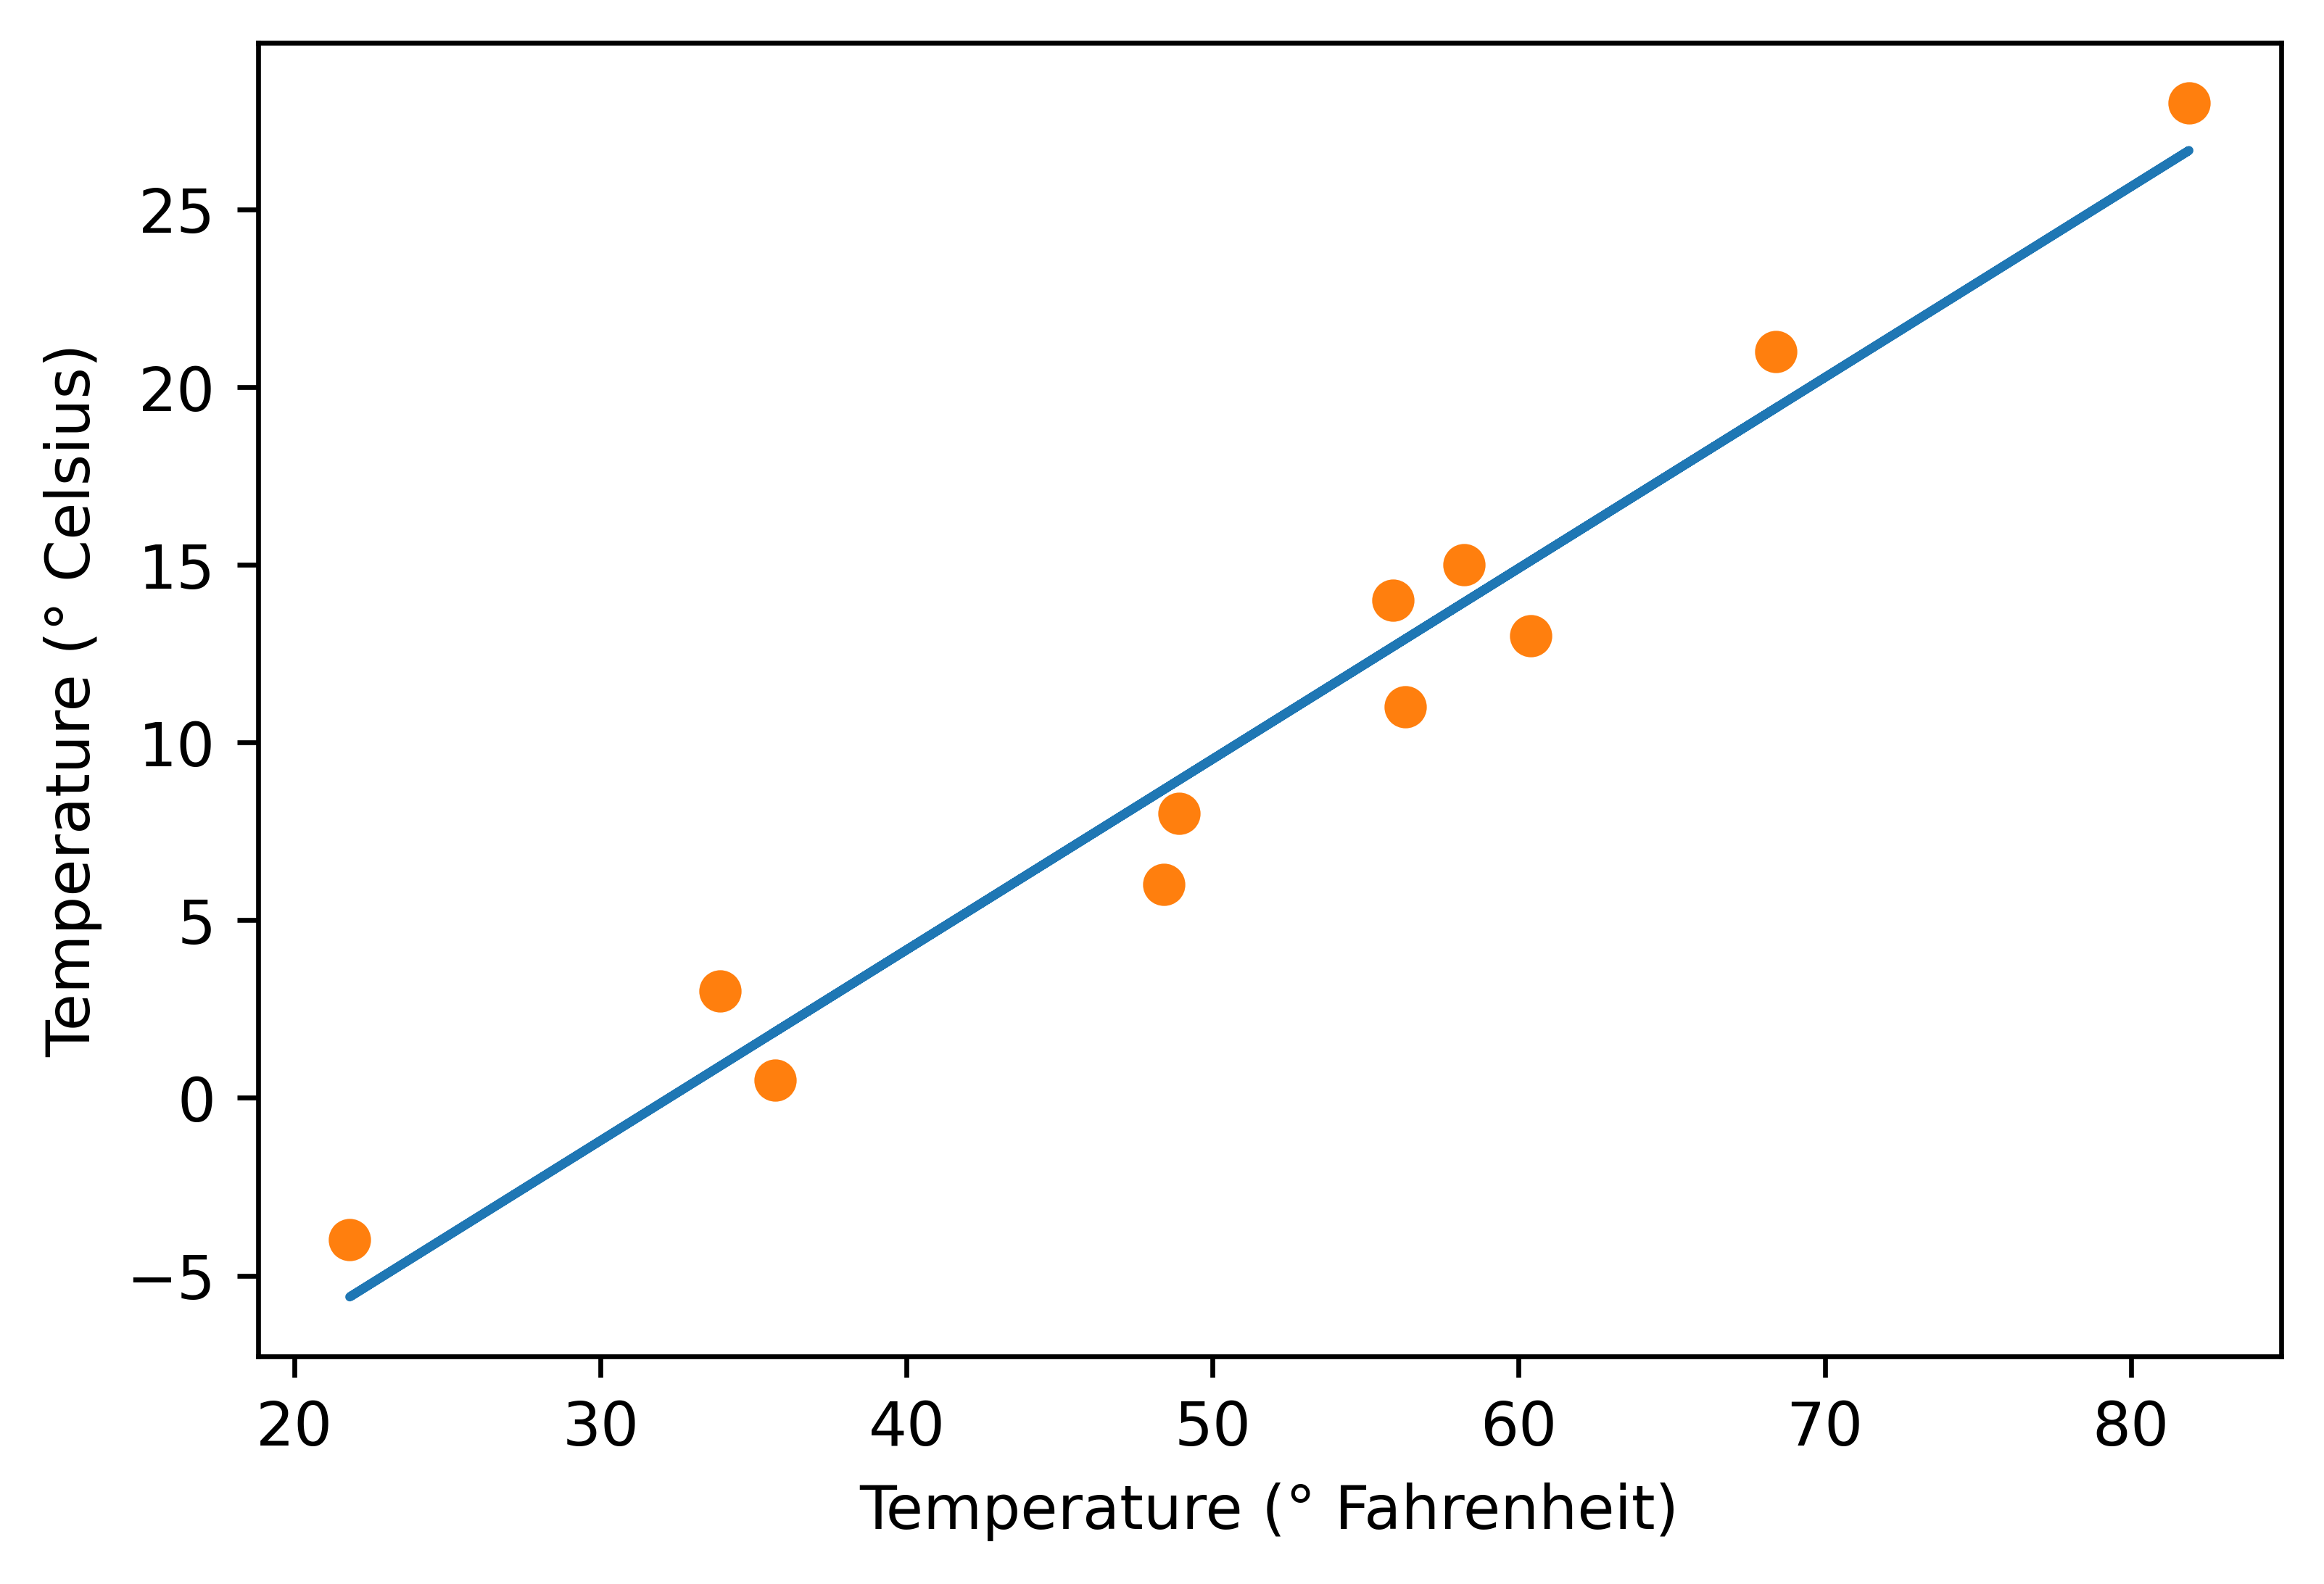

In [29]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,print_params): 
    for epoch in range(1, n_epochs + 1): 
        w, b = params 
        t_p = model(t_u, w, b) 
        loss = loss_fn(t_p, t_c) 
        grad = grad_fn(t_u, t_c, t_p, w, b) 
        params = params - learning_rate * grad 
        if print_params == True:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            print("\t","Params:{}".format(params))
            print("\t","Grad:  {}".format(grad))
    return params

t_un = 0.1 * t_u
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c,
    print_params = False)



%matplotlib inline
from matplotlib import pyplot as plt
t_p = model(t_un, *params)
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (° Fahrenheit)")
plt.ylabel("Temperature (° Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

In [38]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
params.grad is None

True

In [36]:
def model(t_u, w, b):
    return w*t_u + b
def loss_fn(t_p, t_c): 
    squared_diffs = (t_p - t_c)**2  
    return squared_diffs.mean()

loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad #此时，params 的 grad 属性包含关于 params 的每个元素的损失的导数。

tensor([4517.2969,   82.6000])

In [41]:
# 调用 backward()将导致导数在叶节点上累加，因此如果提前调用backward()，则会再次计算损失，
# 再次调用 backward()（就像在任何训练循环中一样），每个叶节点上的梯度将在上一次迭代中计算的梯度之上累加（求和），这会导致梯度计算不正确

loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad #此时，params 的 grad 属性包含关于 params 的每个元素的损失的导数。

tensor([13551.8906,   247.8000])

In [47]:
# 为了防止这种情况发生，我们需要在每次迭代时明确地将梯度归零

if params.grad is not None:
    params.grad.zero_()
    
params.grad

tensor([0., 0.])

In [60]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()

        loss = loss_fn(model(t_u, *params), t_c)
        loss.backward()
        with torch.no_grad():
            params = params - learning_rate * params.grad
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
        # print("\t","Params:{}".format(params))
        # print("\t","Grad:  {}".format(params.grad))
    
    return params

training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad = True),
    t_u = t_un,
    t_c = t_c
)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [64]:
import torch.optim as optim

def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [67]:
# 分割数据集

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [68]:
train_t_u

tensor([55.9000, 35.7000, 48.4000, 58.2000, 21.8000, 33.9000, 68.4000, 60.4000,
        81.9000])